In [360]:
# imports
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import os
import glob
import matplotlib.pyplot as plt
import datetime as dt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, norm, skewnorm, ks_2samp, poisson
from scipy.special import factorial
import matplotlib.dates as mdates
import imp
import numpy.random
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
from collections import OrderedDict
import pickle
#from natsort import natsorted, ns
from copy import deepcopy
import random

def round_nonzero(float_val):
    return(float("{0:.3g}".format(float_val)))

In [2]:
# # important note: all data shows local time (including daylight saving).
# # meteo-data was manually corrected beforehand, it also shows local time including daylight saving

# filename_EDM164 = 'data/SAQN_Messdaten_EDM164_OPC_002_gesamt.pickle'
# filename_ESP8266 = 'data/data-esp8266_all_sensors.pickle'
# filename_meteo = 'data/Meteo_21Oct-31Mai.pickle'
# filename_dylos = 'data/dylos_reference.pickle'



In [3]:
#interactive
def interactive(interactive):
    if interactive:
        %matplotlib
        import matplotlib.pyplot as plt
        plt.ion()
    if interactive == False:
        %matplotlib inline

# convert cm to inch for figsize
def cm2inch(value):
    return value/2.54
# used file formats for saving

# fileformats = ['pdf', 'eps', 'png', 'svg']
# fileformats = ['png', 'pdf']
fileformats = ['png']
dpi = 300
figsize=(cm2inch(30),cm2inch(10))

In [4]:
interactive(False)
# interactive(True)

In [5]:
# color palette for plots

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [6]:
# # load data from pickle files

# data = {}
# with open(filename_EDM164, 'rb') as handle:
#     data['EDM164'] = pickle.load(handle)
    
# with open(filename_ESP8266, 'rb') as handle:
#     data['ESP8266'] = pickle.load(handle)
    
# with open(filename_meteo, 'rb') as handle:
#     data['meteo'] = pickle.load(handle)
    
# with open(filename_dylos, 'rb') as handle:
#     data['dylos'] = pickle.load(handle)

In [7]:
###https://matthew-brett.github.io/teaching/string_formatting.html

# Working with the cleaned Data

In [579]:
# not calibrated if using upper one so change name    
SDS_stat_calibrated = {}
with open("all_SDS_data_cleaned.pickle", 'rb') as handle:
#with open("SDS_stat_calibrated.pickle", 'rb') as handle:
    SDS_stat_calibrated = pickle.load(handle)

In [580]:
cutoff = 20

calibrated_data = pd.DataFrame(index=SDS_stat_calibrated["ref"].keys(),columns=["PM10"])
# for i in range(len(SDS_stat_calibrated)):
#     time_stamp = SDS_stat_calibrated["ref"].keys()[i]
#     all_SDS_data_cleaned["PM10"][time_stamp] = [x for x in all_SDS_data["PM10"][i] if (np.isnan(x) != True)]

for thisdate in calibrated_data["PM10"].keys():
    calibrated_data["PM10"][thisdate] = []

for thissensor in SDS_stat_calibrated:
    for thisdate in SDS_stat_calibrated[thissensor].keys():
#         if np.isnan(SDS_stat_calibrated[thissensor][thisdate]) == False: #filter out nans
        if SDS_stat_calibrated[thissensor][thisdate] < cutoff: #filter out nans AND stay below cutoff
            calibrated_data["PM10"][thisdate].append(SDS_stat_calibrated[thissensor][thisdate])

In [581]:
#use calibrated data
all_SDS_data_cleaned = calibrated_data

In [582]:
#add columns for mean, std and len of all values in that interval
mean_temp = []
std_temp = []
count_temp = []

for thisindex in all_SDS_data_cleaned["PM10"].keys():
    if len(all_SDS_data_cleaned["PM10"][thisindex]) < 2: #drop row if it has only one value
        all_SDS_data_cleaned = all_SDS_data_cleaned.drop(index=thisindex)

for thistuple in all_SDS_data_cleaned["PM10"]:
    mean_temp.append(np.mean(thistuple))
    std_temp.append(np.std(thistuple))
    count_temp.append(len(thistuple))

all_SDS_data_cleaned["mean"] = mean_temp
all_SDS_data_cleaned["std"] = std_temp
all_SDS_data_cleaned["count"] = count_temp

## Check whether there is a significant increase in std_of_stds over time

In [583]:
monthly_frames = {} 

for year in ["2017","2018"]:
    for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:

        date = str(year) + "-" + str(month)

        #sort observations into monthly intervals
        if len(all_SDS_data_cleaned.loc[date : date]) != 0:
            monthly_frames[date] = all_SDS_data_cleaned.loc[date : date]


In [584]:
for thisdate in monthly_frames.keys():
    print(thisdate + "   " + str(round_nonzero(np.mean(monthly_frames[thisdate]["std"]))))
#kein signifikanter alterungsprozess erkennbar... ist das überhaupt die richtige größe?
#annahme: alterung vergrößert streuung = std. d.h. wenn ich die stds jedes tuples anschaue sollten sowohl
#  std of std und mean of std größer werden. absolut nicht erkennbar. 

2017-10   1.76
2017-11   1.53
2017-12   1.62
2018-01   1.11
2018-02   1.58
2018-03   1.21
2018-04   1.57
2018-05   2.85
2018-06   1.42


## Check if there is a significant increase in std for higher measurements 

In [585]:
step_range = 5
current_level = 0
value_frames = {}

while len(all_SDS_data_cleaned.query("mean > " + str(current_level) + " & mean < " + str(current_level + step_range))) > 0:
    value_frames[str(current_level)] = all_SDS_data_cleaned.query("mean > " + str(current_level) + " & mean < " + str(current_level + step_range))
    current_level += step_range

In [586]:
value_std_list = []
value_key_list = []

for thiskey in value_frames.keys():
    value_std_list.append(np.mean(value_frames[thiskey]["std"]))
    value_key_list.append(float(thiskey))
    print(str(thiskey) + "   " + str(round_nonzero(np.mean(value_frames[thiskey]["std"]))) + " with total number of tuples: " + str(len(value_frames[thiskey]["std"])))

0   0.709 with total number of tuples: 1824
5   2.2 with total number of tuples: 1283
10   2.98 with total number of tuples: 734
15   1.78 with total number of tuples: 181


array([ 0.64497252,  0.4846523 , -0.02699908])

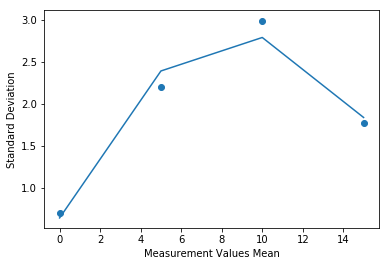

In [587]:
plt.scatter(value_key_list, value_std_list)


fit_function = poly.polyfit(value_key_list, value_std_list, 2)
x_fit_func = np.linspace(min(value_key_list), max(value_key_list), len(value_key_list))
y_fit_func = poly.polyval(x_fit_func, fit_function)
plt.plot(x_fit_func, y_fit_func)
plt.ylabel('Standard Deviation');
plt.xlabel('Measurement Values Mean');

##off + lin*x + quad*x^2
#off, lin, quad = fit_function

fit_function

In [588]:
#looks like significant increase in std with value height

## Check aging again in certain slices of pollution

In [589]:
monthly_frames_sliced = {} 

lower_bound = 0
upper_bound = 20
dataframe_slice = all_SDS_data_cleaned.query("mean > " + str(lower_bound) + " & mean < " + str(upper_bound))

for year in ["2017","2018"]:
    for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:

        date = str(year) + "-" + str(month)
        
        #sort observations into monthly intervals
        if len(dataframe_slice.loc[date : date]) != 0:
            monthly_frames_sliced[date] = dataframe_slice.loc[date : date]


In [590]:
age_std_list = []
age_key_list = []

for thisdate in monthly_frames_sliced.keys():
    age_std_list.append(np.mean(monthly_frames_sliced[thisdate]["std"]))
    age_key_list.append(thisdate)
    print(thisdate + "   " + str(round_nonzero(np.mean(monthly_frames_sliced[thisdate]["std"]))))

#annahme: alterung vergrößert streuung = std. d.h. wenn ich die stds jedes tuples anschaue sollten sowohl
#  std of std und mean of std größer werden. absolut nicht erkennbar. 

2017-10   1.76
2017-11   1.53
2017-12   1.62
2018-01   1.11
2018-02   1.58
2018-03   1.21
2018-04   1.57
2018-05   2.85
2018-06   1.42


array([ 1.6857787 , -0.15569185,  0.0249355 ])

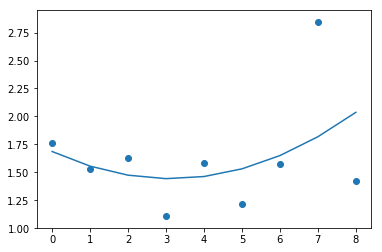

In [591]:
age_key_list_ints = range(0,len(age_key_list))

plt.scatter(age_key_list_ints, age_std_list)


fit_function = poly.polyfit(age_key_list_ints, age_std_list, 2)
x_fit_func = np.linspace(min(age_key_list_ints), max(age_key_list_ints), len(age_key_list_ints))
y_fit_func = poly.polyval(x_fit_func, fit_function)
plt.plot(x_fit_func, y_fit_func)

##off + lin*x + quad*x^2
#off, lin, quad = fit_function
fit_function

In [592]:
#zeigt jetzt teils recht gut alterseffekte --> signifikanzen errechnen, macht es sinn dass alterseffekte
#auch abhängig sind von der werthöhe?
#vielleicht kommt der quadratische zusammenhang aus dem produkt alter*werthöhe ?

#noch statistische größen zur bewertung der fits finden

In [593]:
# alles hier drunter muss noch um alter und werthöhe korrigiert werden
# am besten eine funktion finden, die mit input wert und zeit ab anfang den entsprechenden korrekturfaktor
# berechnet und den korrigierten wert ausgibt

# ehrlich gesagt, macht das überhaupt sinn? um was will ich denn korrigieren? 
# eher einfach alles oberhalb von ~20 abschneiden

In [594]:
# ist das auf poisson prozess zurückführbar? je höher erwartungswert desto höher streuung?
# poisson prozess: poisson distr an jedem punkt -> zusammenhang der verteilungen ist durch faktor bestimmt
 # --> feinphone paper

# kombinatorisch wegen rand? reiskörner auf schachbrett <--> counts im zeitfenster? 


# poisson zusammenhang von erwartungswert und varianz --> aus rauschen das signal errechnen

## For two values: calculate the difference

In [608]:
randomize_sign = False
absolute_differences = False


# sort all tuples, stds by the number of observations which they came from
count_of_observations = list(set(list(all_SDS_data_cleaned["count"])))
all_dates = all_SDS_data_cleaned["PM10"].keys()

#create empty dicts
tuple_list = {}
std_list = {}
mean_of_std_list = {}
std_of_std_list = {}

#fill with dataframes
for eachnr in count_of_observations:
    std_list[str(eachnr)] = all_SDS_data_cleaned.query('count == ' + str(eachnr))["std"]
    tuple_list[str(eachnr)] = all_SDS_data_cleaned.query('count == ' + str(eachnr))["PM10"]
    mean_of_std_list[str(eachnr)] = np.mean(all_SDS_data_cleaned.query('count == ' + str(eachnr))["std"])
    std_of_std_list[str(eachnr)] = np.std(all_SDS_data_cleaned.query('count == ' + str(eachnr))["std"])



list_of_diffs = []
for thistuple in tuple_list["2"]:
    if absolute_differences == True:
        the_diff = abs(thistuple[0]-thistuple[1])/2 
    else:
        the_diff = (thistuple[0]-thistuple[1])/2
    if randomize_sign == True:
        rand_sign = random.choice([1,-1])
    else:
        rand_sign = 1    
    list_of_diffs.append(rand_sign * the_diff)

print("Absolute Differences: " + str(absolute_differences) + ", Randomized_signs: " + str(randomize_sign))
print("mean and std of list_of_diffs: mean: " + str(round(np.mean(list_of_diffs),4)) + ", std: " + str(round(np.std(list_of_diffs),4)))

print("mean and std of two value fits: mean: " + str(round(mean_of_std_list["2"],4)) + ", std: " + str(round(std_of_std_list["2"],4)))


#for absolute_values = True it's the same thing: 
#taking (half) the (absolute!) differences and then fitting them
#OR fitting a distribution on two values and taking the stds and then fitting them again. std of two value is half the diff
#visuals below

Absolute Differences: False, Randomized_signs: False
mean and std of list_of_diffs: mean: -1.3308, std: 1.8663
mean and std of two value fits: mean: 1.6407, std: 1.6006


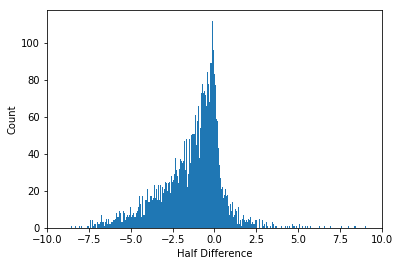

In [609]:
#%matplotlib inline
plt.hist(list_of_diffs, bins=300)
plt.ylabel('Count');
plt.xlabel('Half Difference');
plt.xlim(-10,10);

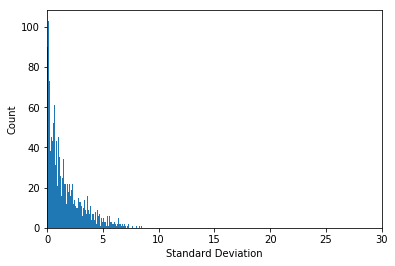

In [610]:
#%matplotlib inline
plt.hist(std_list["2"], bins=300)
plt.ylabel('Count');
plt.xlabel('Standard Deviation');
plt.xlim(0,30);

# Check for Poisson Distribution

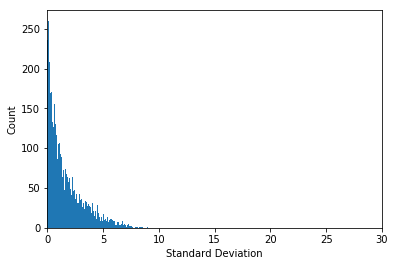

In [611]:
#%matplotlib inline
plt.hist(std_list["2"], bins=100)
plt.ylabel('Count');
plt.xlabel('Standard Deviation');
plt.xlim(0,30);

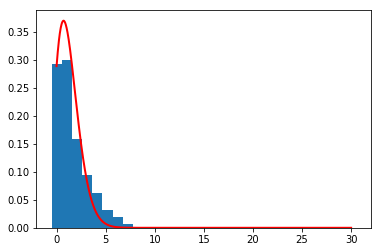

fitted poisson mu = 1.24


In [612]:
#check for poisson distribution

# get poisson deviated random numbers
#data = np.random.poisson(2, 1000)
data=std_list["2"]
#data=list_of_diffs

#integer steps require a relation between bin count and x-axis label
poisson_range = 30

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=poisson_range, range=[-0.5, poisson_range + 0.5], density=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson_func(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson_func, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_poisson = np.linspace(0, poisson_range, 1000)

plt.plot(x_poisson, poisson_func(x_poisson, *parameters), 'r-', lw=2)
plt.show()

print("fitted poisson mu = " + str(round_nonzero(parameters[0])))

In [613]:
# KS sagt allen std_lists liegt die gleiche distribution zugrunde. das macht nur sinn, alles andere wäre unfug. 
#klappt nicht mehr, WARUM?

print("comparing 2 and 3 tuple results: p-value: " + str(round_nonzero(ks_2samp(std_list["2"],std_list["3"])[1])))

comparing 2 and 3 tuple results: p-value: 0.0306


comparing 2 and poisson fit: p-value: 5.52069026109467e-147


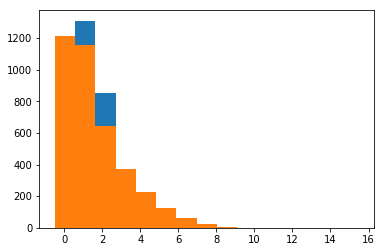

In [614]:
bincount = 15
std_poisson = std_list["2"]
random_poisson = np.random.poisson(parameters[0], len(std_poisson))

plt.hist(random_poisson, bins=bincount, range=[-0.5, bincount + 0.5]);
plt.hist(std_poisson, bins=bincount, range=[-0.5, bincount + 0.5]);

# KS sagt auch, es ist KEINE poisson distribution

print("comparing 2 and poisson fit: p-value: " + str(ks_2samp(std_poisson,random_poisson)[1]))

## Analyse difference without taking abs

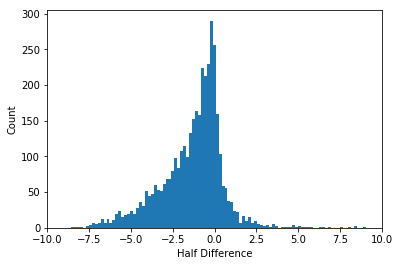

In [615]:
#%matplotlib inline
plt.hist(list_of_diffs, bins=100)
plt.ylabel('Count');
plt.xlabel('Half Difference');
plt.xlim(-10,10);

# Test for Skewed Normal Distribution

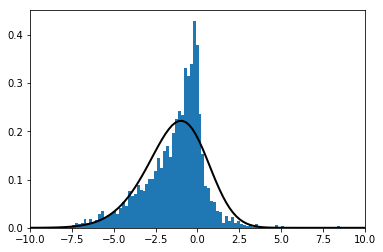

In [616]:
# choose some parameters
a_skew, mu, std = skewnorm.fit(list_of_diffs)
# Plot the PDF.
plt.figure()
plt.hist(list_of_diffs, bins=100, density=True)
plt.xlim(-10,10)

x = np.linspace(-10, 10, 100)
p = skewnorm.pdf(x,a_skew, mu, std)
plt.plot(x, p, 'k', linewidth=2);

In [617]:
print("a_skew = " + str(a_skew))
print("mu = " + str(mu))
print("std = " + str(std))

# KS sagt es ist auch keine skewed normalverteilung
ks_2samp(list_of_diffs,p)

a_skew = -1.6793577661908512
mu = 0.39192502341237
std = 2.5398403278929607


Ks_2sampResult(statistic=0.8209812108559499, pvalue=5.250788932609696e-59)

# Test wie sich differenz von normalverteilten werten verhält

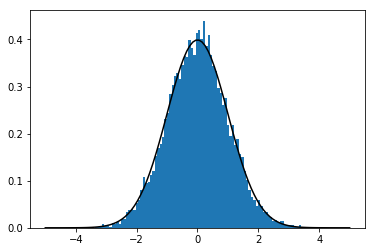

In [618]:
std_test = 1

x = np.linspace(-5, 5, 100)
p = norm.pdf(x,0,std_test)

y = np.random.normal(0, std_test, 10000);
plt.hist(y, bins=100, density=True);

plt.plot(x, p,'k');

mu: 0.0304   std: 1.42


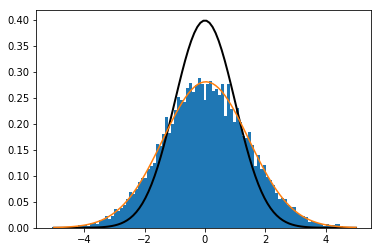

In [619]:
y_2 = np.random.normal(0, std_test, 10000);
y_diff = y-y_2
plt.hist(y_diff, bins=100, density=True);

plt.plot(x, p, 'k', linewidth=2);

mu_2, std_2 = norm.fit(y_diff)
p_2 = norm.pdf(x, mu_2, std_2)
plt.plot(x, p_2);
print("mu: " + str(round_nonzero(mu_2)) + "   std: " + str(round_nonzero(std_2)))

### Differenz von zwei Normalverteilungen ist auch Normalverteilung mit 1.4 facher std

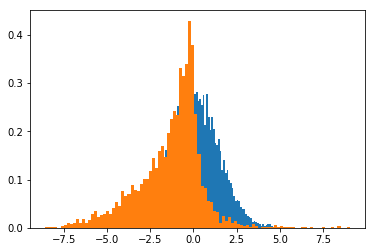

In [620]:
plt.hist(y_diff, bins=100, density=True);
plt.hist(list_of_diffs, bins=100, density=True);

In [621]:
print("vgl mit data, p value: " + str(round_nonzero(ks_2samp(list_of_diffs,y_diff)[1])))

vgl mit data, p value: 8.65e-265


### KS sagt werte kommen auch nicht aus differenz von normalverteilungen

# Calculate the difference of values from a skewed normal distribution and compare with the data

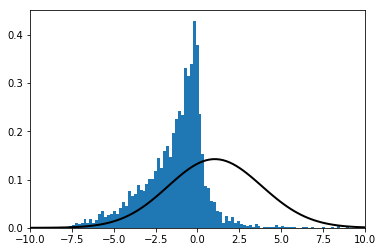

In [622]:
# guess some parameters
a_skew, mu, std = (0.5,0,3)

#skew function for comparison
x = np.linspace(-10, 10, 100)
p = skewnorm.pdf(x,a_skew, mu, std)
plt.xlim(-10,10)

# Plot the PDF.
plt.hist(list_of_diffs, bins=100, density=True)
plt.plot(x, p, 'k', linewidth=2);

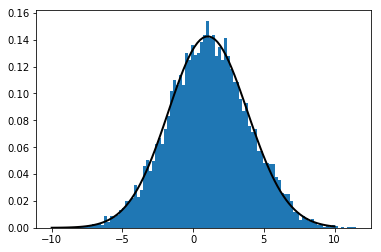

In [623]:
#code for generate random numbers based on skewed normal distribution and comparison with fit function

r = skewnorm.rvs(a_skew, mu, std,size=10000)
plt.hist(r,bins=100,density=True);

plt.plot(x,p, 'k', linewidth=2);

Generating Distribution: 
mu: 0   std: 3   a_skew: 0.5
Difference Distribution: 
mu: 0.0146   std: 3.99


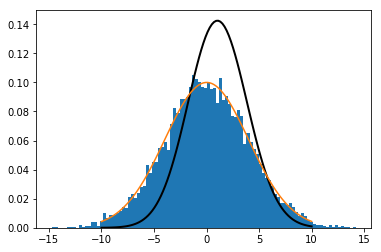

In [624]:
r_2 = skewnorm.rvs(a_skew, mu, std,size=10000)
r_diff = r-r_2
plt.hist(r_diff, bins=100, density=True);

plt.plot(x, p, 'k', linewidth=2);

mu_2, std_2 = norm.fit(r_diff)
p_2 = norm.pdf(x, mu_2, std_2)
plt.plot(x, p_2);
print("Generating Distribution: ")
print("mu: " + str(mu) + "   std: " + str(std) + "   a_skew: " + str(a_skew))
print("Difference Distribution: ")
print("mu: " + str(round_nonzero(mu_2)) + "   std: " + str(round_nonzero(std_2)))

In [625]:
norm_comparison = norm.rvs(mu_2, std_2, size=500)
print("Check via KS that the difference of two points of the skewed normal distribution is a normal distribution")
print("p-value: " + str(round_nonzero(ks_2samp(r_diff,norm_comparison)[1])))

Check via KS that the difference of two points of the skewed normal distribution is a normal distribution
p-value: 0.786


### Differenz zweier Skewed Normalverteilungen ist immer Normalverteilung (!) Skew beeinflusst nur die std

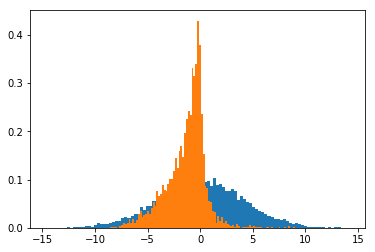

In [626]:
plt.hist(r_diff, bins=100, density=True);
plt.hist(list_of_diffs, bins=100, density=True);

In [627]:
# sehe hier möglicherweise den offset eines sensors gegenüber einem anderen 
#--> differenz in eine Richtung verschoben, müsste es zufällig machen welche zahl ich von welcher abziehe
#--> auch mit random sign auf den differenzen klappts nicht. wird symmetrisch aber ist unten zu breit und oben zu steil
# --> spricht aber für einen systematischen fehler: zu viele zu hohe werte? allerdings nicht nachvollziehbar, da ich
#   differenzen zum gleichen zeitpunkt (alter) und gleicher wertehöhe anschaue... 
#   allerdings: wenn die streuung zunimmt, dann bekomme ich auch höhere differenzen mit höherer wahrscheinlichkeit!
# --> verschieden zeiten anschauen
# --> werthöhen unterscheiden

#KS sagt werte kommen auch nicht aus differenz von normalverteilungen
print("p-value: " + str(round_nonzero(ks_2samp(list_of_diffs,r_diff)[1])))

p-value: 0.0


In [628]:
norm.fit(list_of_diffs)

(-1.3308063674321502, 1.8662607859208549)